In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/AI and ML Workshop/Week-4/Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Test'


In [4]:

# Loading the images
def load_images(dataset_path, image_size=(32, 32)):
    data = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(image_size)
                    img = img_to_array(img) / 255.0  # Normalizing
                    data.append(img)
                except:
                    pass
    return np.array(data)

images = load_images(dataset_path)
images = images.reshape(-1, 32, 32, 1)  # reshaping for CNN input

# Adding noise (Gaussian)
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Splitting the dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoding
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,041 (652.50 KB)

 Trainable params: 167,041 (652.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.5939 - val_loss: 0.3242
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 984ms/step - loss: 0.2867 - val_loss: 0.2301
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 971ms/step - loss: 0.2267 - val_loss: 0.2065
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 979ms/step - loss: 0.2053 - val_loss: 0.1914
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1914 - val_loss: 0.1944
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 974ms/step - loss: 0.1882 - val_loss: 0.1802
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.1794 - val_loss: 0.1728
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 999ms/step - loss: 0.1765 - val_loss: 0.1697
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1714 - val_loss: 0.1671
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 955ms/step - loss: 0.1699 - val_loss: 0.1673
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 986ms/step - loss: 0.1680 - val_loss: 0.1730
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


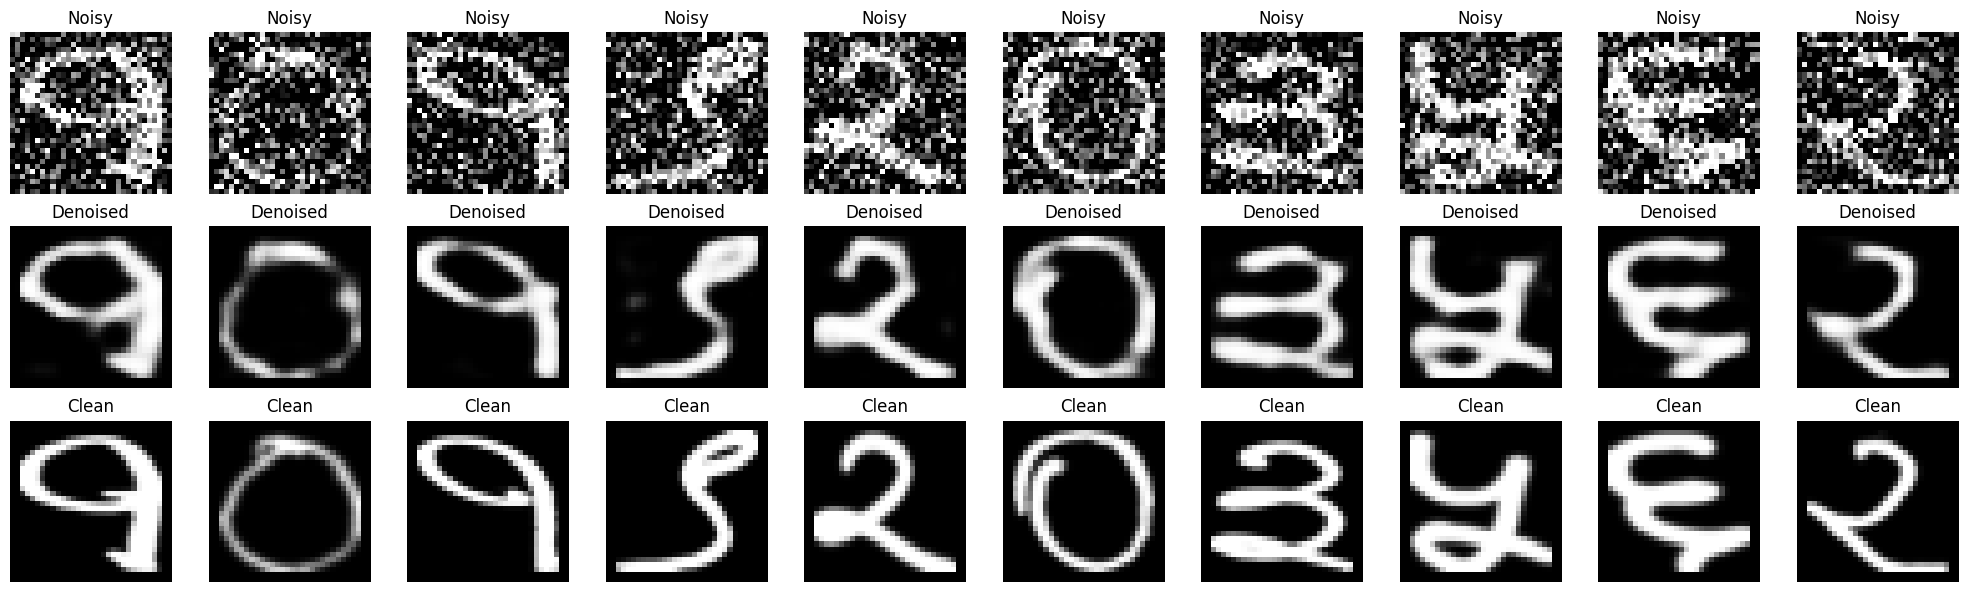

In [7]:
def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoising
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Cleaning
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predicting
denoised_images = autoencoder.predict(x_test_noisy)
plot_images(x_test_noisy, denoised_images, x_test)


In [8]:
def salt_pepper_noise(image, amount=0.01):
    noisy = image.copy()
    row, col, ch = image.shape[1], image.shape[2], image.shape[3]
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 1

    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[1:3]]
    noisy[:, coords[0], coords[1], :] = 0
    return noisy


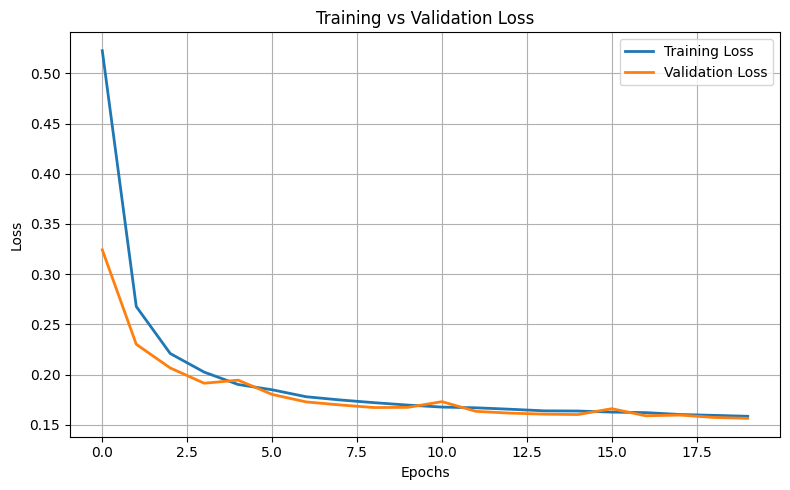

In [9]:
# 3.1 VISUALIZING TRAINING & VALIDATION LOSS

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Step-5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


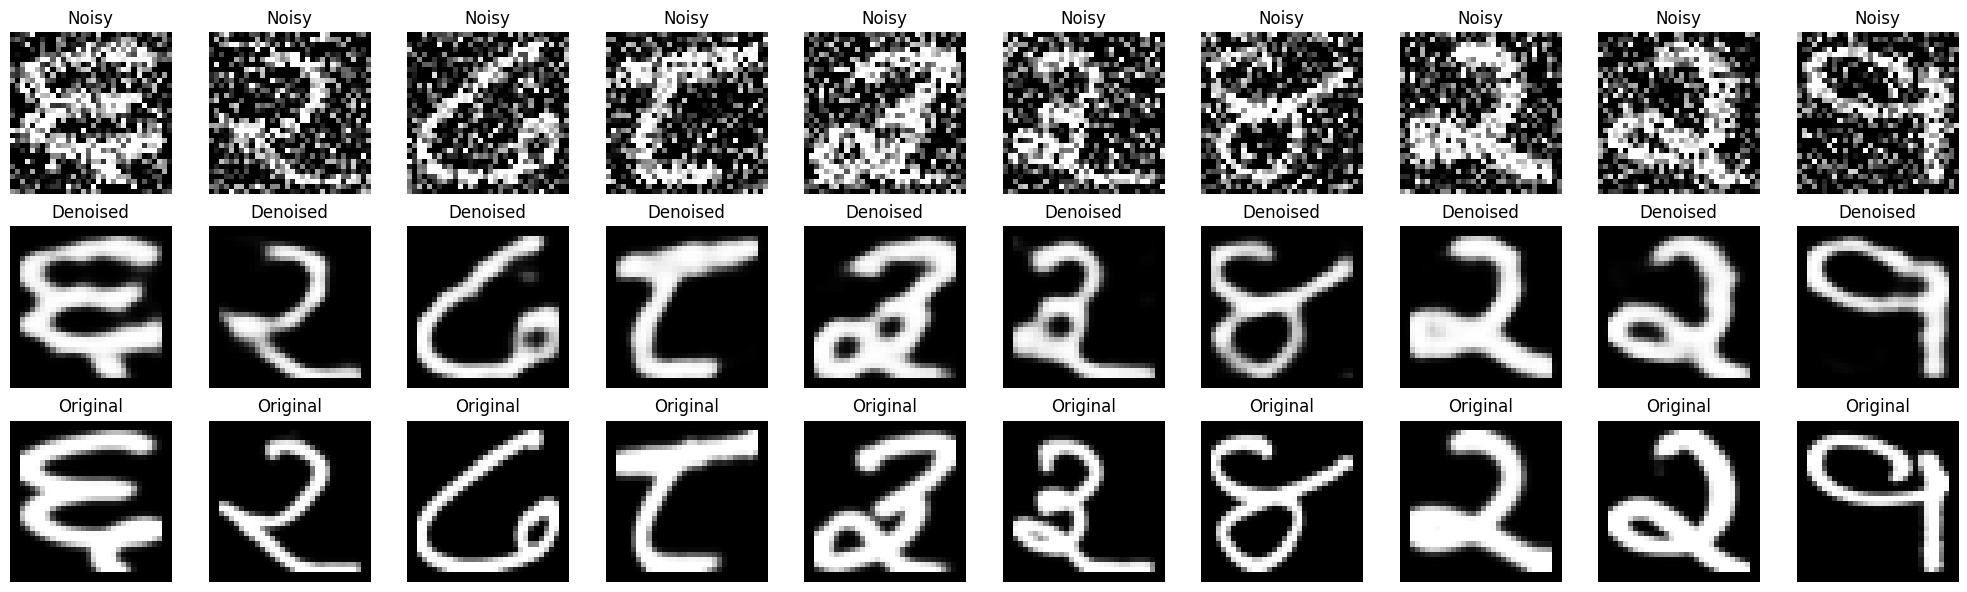

In [11]:
# Visual comparison: Noisy vs Denoised vs Original
n = 10  # Number of samples to display
plt.figure(figsize=(20, 6))

x_val_noisy, _, x_val, _ = train_test_split(x_test_noisy, x_test, test_size=0.2, random_state=42)

for i in range(n):
    # Noisy Input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised Output
    ax = plt.subplot(3, n, i + 1 + n)
    denoised = autoencoder.predict(x_val_noisy[i:i+1])
    plt.imshow(denoised[0].reshape(32, 32), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original Image
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_val[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

Experimenting with Different Noise Levels

In [12]:
noise_levels = [0.1, 0.3, 0.5]
reconstructions = []

for noise in noise_levels:
    noisy_imgs = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    decoded_imgs = autoencoder.predict(noisy_imgs)
    reconstructions.append((noise, noisy_imgs, decoded_imgs))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Visualization of Denoising Performance at Different Noise Levels

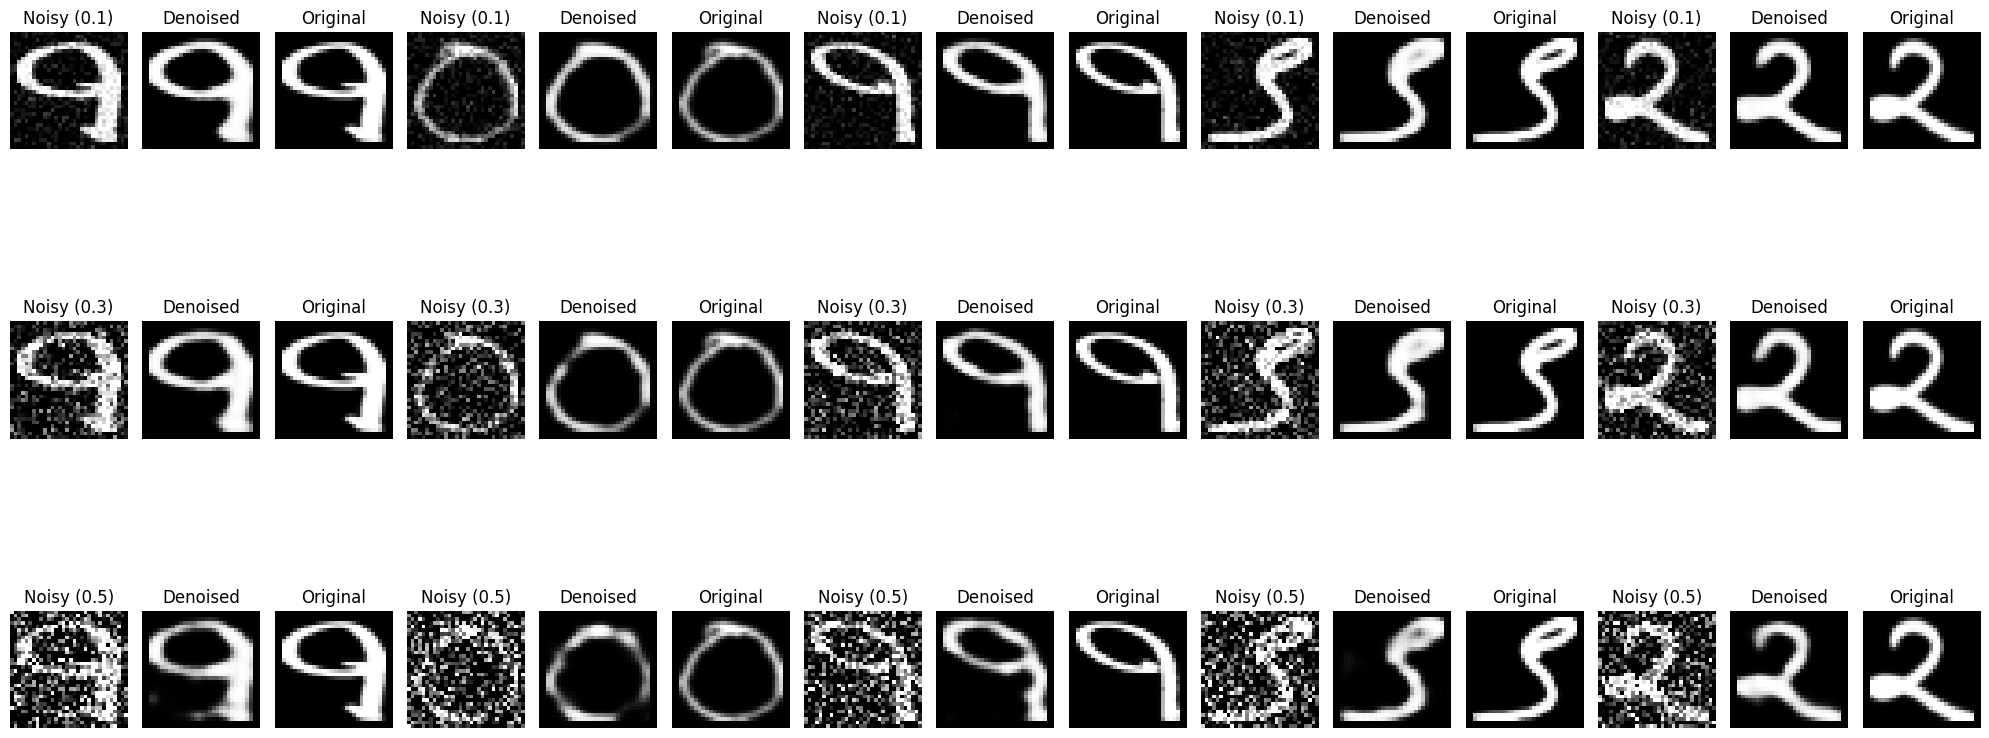

In [13]:
n = 5
plt.figure(figsize=(20, 10))
for idx, (noise, noisy, decoded) in enumerate(reconstructions):
    for i in range(n):
        # Noisy
        ax = plt.subplot(len(noise_levels), n * 3, idx * n * 3 + i * 3 + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title(f"Noisy ({noise})")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(len(noise_levels), n * 3, idx * n * 3 + i * 3 + 2)
        plt.imshow(decoded[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original
        ax = plt.subplot(len(noise_levels), n * 3, idx * n * 3 + i * 3 + 3)
        plt.imshow(x_test[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

plt.tight_layout()
plt.show()
